#Introdução

## Apresentação

Este é o segundo notebook do [Projeto Final do Bootcamp da Alura](https://github.com/renanmath/Bootcamp_Projeto_Final). [Clique aqui](https://github.com/renanmath/Bootcamp_Projeto_Final/tree/main/notebooks) para acessar os demais notebooks.

No primeiro notebook, fizemos o tratamento dos dados e uma análise exploratória. Ao final dele, geramos um arquivo csv com os dados já preparados e subimos uma cópia no repositório do projeto no Github, de onde iremos acessá-lo remotamente. 

Este notebook está organizado da seguinte maneira:
- Introdução
- Importação das bibliotecas e criação das funções
- Importação dos dados
- Criação das variáveis
- Criação do modelo baseline (modelo simples)
- Criação dos modelos intermediários
- Criação do modelo final
- Considerações finais

## Entendendo o problema

Como vimos no primero notebook, esse projeto é inspirado em um desafio proposto pelo Hospital Sírio Libanês no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). Os dados apresentados contém informações sobre alguns pacientes do hospital. Essas informações são:
- Dados demográficos
- Resultados dos testes sanguíneos
- Medições de sinais vitais
- Janela de tempo de internação
- Se o paciente foi ou não para a UTI

A partir desses dados, o desafio propõe criar modelos preditivos que possam responder as seguintes perguntas:


1.   O paciente irá para a UTI nas próximas horas?
2.   O paciente não irá para a UTI nas próximas horas?



Apesar de parecidas, essas duas perguntas são distintas. Um modelo que possa responder satisifatoriamente uma delas, não necessariamente será bom para responder a outra. Para entender isso melhor, precisamos discutir brevemente algumas métricas que serão usadas em nossos estudos.

A *acurácia* ('*score*', em inglês) é provavelmente a métrica mais lembrada, embora não a mais importante. Ela é definida  como o total de acertos / total de amostras. Ele, entretanto, não consegue capturar sutilezas que outras métricas levam em contam, e por isso é um tanto imprecisa.

Uma boa maneira de começar a melhorar a análise da performace de um modelo é verificar sua *matriz de confusão* ('*confusion matrix*'). Nas linhas dessa matriz temos os resultados reais e nas colunas temos os resultados previstos pelo modelo, de acordo com cada classe.

Em problemas de classificação binária, será uma matrix 2x2.

Nas células dessa matriz, temos 4 informações importantes:

- VP = número de verdadeiros positivos (modelo previu que era positivo e de fato era positivo)
- VN = número de verdadeiros negativos (modelo previu que era negativo e de fato era negativo)
- FP = número de falsos positivos (modelo previu que era positivo, mas na verdade era negativo)
- FN = número de falsos negativos (modelo previu que era negativo, mas na verdade era positivo)

Temos métricas que levam esses números em conta:

- precisão de positos = VP/(VP+FP)
- precisão de negativos = VN/(VN+FN)
- recall (ou revocação) de positivos = VP/(VP+FN)
- recall (ou revocação) de negativos = VN/(VN+FP)
- F1 = média harmônica entre presicão e revocação

Com essas terminologias, podemos dizer de forma mais precisa quando um modelo é bom para resolver o problema 1 e quando é bom para resolver o problema 2. No primeiro caso, queremos evitar falsos positivos; no segundo, queremos evitar falsos negativos. Assim:

- Um modelo que é bom em prever se um paciente irá para a UTI deve ter valores altos de precisão de positivos e revocação de negativos, pois ele prevê poucos falsos positivos. 
- Um modelo que é bom em prever se um paciente não irão para a UTI deve ter valores altos de precisão de negativos e revocação de positivos, pois ele prevê poucos falsos negativos. 

Como veremos, balancear essas métricas podem ser muito complicado. No geral, foi mais fácil responder o problema 2.

Como visto também no primeiro notebook, o banco de dados inicial continha uma coluna WINDOW, que mostra a janela de tempo (desde a admissão) de referência para os dados de cada linha. Os possíveis valores eram:
- 0-2 -----> de zero a duas horas após a adimissão
- 2-4 -----> de duas a quatro horas após a adimissão
- 4-6 -----> de quatro a seis horas após a adimissão
- 6-12 ----> de seis a doze horas após a adimissão
- ABOVE12 --> mais de doze horas após a adimissão

Já para a coluna ICU (nossa variável target):
- 0 ---> o paciente não foi internado na UTI naquela janela de tempo
- 1 ---> o paciente foi internado na UTI naquela janela de tempo

Segundo as instruções do Sírio Libanês, duas premissas básicas devem ser consideradas na resolução do desafio:
- Não utilizar dados de uma linha para a qual a variável alvo é igual a 1. Isso é razoável, pois queremos prever quando um paciente irá para a UTI com antecedêcia, então não faz sentido alimentar o modelo com dados de um momento em que o evento que ele deveria prever já ocorreu. 
- Quanto maior a antecedência da previsão, melhor. Por isso, tomamos a decisão, no notebook anterior, de utilizar apenas dados da primeira janela de tempo.

# Importação das bibliotecas e funções

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import warnings
import math
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree 

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_roc_curve

In [5]:
def roda_modelo_cv(modelo, dados, x,y, n_splits = 5, n_repeats = 10, tipo_score = 'roc_auc'):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats, random_state=527435)
    #resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring= tipo_score, return_train_score=True)

    auc_medio_teste = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_teste_std = np.std(resultados['test_score'])
    auc_treino_std = np.std(resultados['train_score'])
    
    linf_teste = auc_medio_teste - 2*auc_teste_std
    lsup_teste = auc_medio_teste + 2*auc_teste_std
    
    linf_treino = auc_medio_treino - 2*auc_treino_std
    lsup_treino = auc_medio_treino + 2*auc_treino_std
    

    print(f'{tipo_score} médios \n |  Teste --- Treino | \n | {round(100*auc_medio_teste,2)}% ---- {round(100*auc_medio_treino,2)}% |')
    print(f'Intervalo de 2 desvios padrões \n | Teste -------------- Treino | \n | ({round(100*linf_teste, 2)}%, {round(100*lsup_teste, 2)}%) -- ({round(100*linf_treino, 2)}%, {round(100*lsup_treino, 2)}%)|')
    #return auc_medio, auc_medio_treino
   

In [6]:
from sklearn.metrics import roc_auc_score

In [7]:
def compara_lista_series_binarias(lista, tolerancia = 25, prob = False):
  if len(set([len(x) for x in lista])) > 1:
    print('ERRO: séries com comprimentos distintos')
    return False 

  n = len(lista[0])
  tl = min([tolerancia, n-1])
  resultado = []

  for i in range(0,n):
    soma = 0
    for j in range(0,len(lista)):
      soma = soma + lista[j][i]
    if prob == False:
      if soma > tl:
        resultado.append(1)
      else:
        resultado.append(0)
    else:
      resultado.append(soma/len(lista))

  return resultado

In [8]:
def analisa_prob_series(lista, corte = 'auto', percentil = 0.25):
  if len(lista) != 3:
    print('Erro! Lista deve conter 3 séries')
    return False
  if len(lista[0]) != len(lista[1]):
    print('Erro! As duas primeiras séries devem ter mesmo comprimento')
    return False
  
  if isinstance(corte, int):
    corte = float(corte)

  if corte == 'auto':
    dict_prob = {'Real': lista[0], 'Prob' : lista[1]}
    df_treino = pd.DataFrame(dict_prob)
    corte = df_treino.query('Real == 1')['Prob'].quantile(percentil)
    q0 = df_treino.query('Real == 0')['Prob'].quantile(1)
    print(f'O máximo do 0 é {q0}')
    #if q0 < corte:
      #corte = q0

  if isinstance(corte, float) == False:
    print('Erro! Valor de corte não identificado')
    return False
  
  if corte > 1 or corte < 0:
    print('Erro! Valor de corte deve ser um float entre 0 e 1 ou "auto"')

  resultado = []
  A = lista[2]
  n = len(A)
  print(f'Valor de corte = {corte}')

  for i in range(0,n):
    if A[i] >= corte:
      resultado.append(1)
    else:
      resultado.append(0)

  return resultado

In [9]:
def modelo_repetido(estimador, X_train, y_train, X_test, y_test, n_rep = 10, n_folds = 5,
                    tol = 25, tol_overfit = 0.95, prob = False, corte = 'auto', percentil = 0.25, verbosity = 1):
  
  from sklearn.model_selection import RepeatedStratifiedKFold
  from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score, roc_auc_score

  kfold = RepeatedStratifiedKFold(n_splits= n_folds, n_repeats= n_rep, random_state=527435)
  lista_pred_teste = []
  lista_pred_treino = []
  cont = 0
  cont_overfit = 0
  for train_index, test_index in kfold.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    estimador.fit(X_train_fold, y_train_fold)
    
    acc_treino = accuracy_score(y_train_fold,estimador.predict(X_train_fold))
    if acc_treino < tol_overfit:
      acc_teste = accuracy_score(y_test_fold, estimador.predict(X_test_fold))
      y_pred_teste = estimador.predict(X_test)
      lista_pred_teste.append(y_pred_teste.tolist())
      y_pred_treino = estimador.predict(X_train)
      lista_pred_treino.append(y_pred_treino)
      cont = cont + 1
    else:
      cont_overfit = cont_overfit +1
  
  n = len(y_test)
  if cont == 0:
    print('Não foram encontados modelos sem overfitting')
    return False, False

  if verbosity != 0:
    print(f'Foram realizadas {n_folds*n_rep} iterações')
    print(f'Serão utilizados {cont} modelos no processo')
    print(f'Um total de {cont_overfit} modelos tiveram overfitting com os dados de treino')

  previsao_teste = compara_lista_series_binarias(lista_pred_teste, tolerancia= tol, prob = prob)
  previsao_treino = compara_lista_series_binarias(lista_pred_treino, tolerancia = tol, prob = prob)
  if prob == False:
    previsao = [previsao_teste, previsao_treino]

    if verbosity != 0:
      print('\n || Relatório de classificação (dados de teste) || \n')
      print(classification_report(y_test, previsao_teste))
      print('\n || Relatório de classificação (dados de treino) || \n')
      print(classification_report(y_train, previsao_treino)) 

    acc = [round(100*accuracy_score(y_test,previsao_teste),2), round(100*accuracy_score(y_treino,previsao_treino),2)]
    prec = [round(100*precision_score(y_test,previsao_teste),2), round(100*precision_score(y_train,previsao_treino),2)]
    recall = [round(100*recall_score(y_test,previsao_teste),2), round(100*recall_score(y_train,previsao_treino),2)]
    f1 = [round(100*f1_score(y_test,previsao_teste),2), round(100*f1_score(y_train,previsao_treino),2)]
  else:
    previsao_y = analisa_prob_series([y_train.tolist(), previsao_treino, previsao_teste], corte = corte, percentil= percentil)
    if verbosity != 0:
      print('\n || Relatório de classificação (dados de teste) || \n')
      print(classification_report(y_test, previsao_y))
    acc = round(100*accuracy_score(y_test,previsao_y),2)
    prec = round(100*precision_score(y_test,previsao_y),2)
    recall = round(100*recall_score(y_test,previsao_y),2)
    f1 = round(100*f1_score(y_test,previsao_y),2)
    previsao = previsao_y


  dict_scores = {
      'Acuracia': acc,
      'Precisão' : prec,
      'Revocação' : recall,
      'F1' : f1
                 }

  return previsao, dict_scores

# Importação dos dados

Vamos importar o dataframe criado no notebook anterior. Ele foi guardado na pasta Dados do repositório desse projeto, no Github.

In [10]:
url = 'https://raw.githubusercontent.com/renanmath/Bootcamp_Projeto_Final/main/Dados/dados_resumidos_UTI'

In [11]:
dados_resumidos = pd.read_csv(url)
dados_resumidos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,...,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
0,0,1,0.6,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.183673,0.183673,0.183673,0.183673,-0.891993,-0.891993,-0.891993,-0.891993,0.090147,0.090147,0.090147,0.090147,0.109756,0.109756,0.109756,0.109756,1.000000,1.000000,1.000000,1.000000,-0.835844,-0.835844,-0.835844,...,-0.518519,-0.518519,-0.518519,0.345679,0.345679,0.345679,0.345679,-0.028571,-0.028571,-0.028571,-0.028571,-0.836145,-0.836145,-0.836145,-0.836145,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,0-2,1
2,2,0,0.1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.357143,0.357143,0.357143,0.357143,-0.780261,-0.780261,-0.780261,-0.780261,0.144654,0.144654,0.144654,0.144654,0.158537,0.158537,0.158537,0.158537,1.000000,1.000000,1.000000,1.000000,-0.382773,-0.382773,-0.382773,...,-0.703704,-0.703704,-0.703704,0.345679,0.345679,0.345679,0.345679,0.085714,0.085714,0.085714,0.085714,-0.836145,-0.836145,-0.836145,-0.836145,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,0-2,1
3,3,0,0.4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.326531,0.326531,0.326531,0.326531,-0.891993,-0.891993,-0.891993,-0.891993,-0.203354,-0.203354,-0.203354,-0.203354,-0.219512,-0.219512,-0.219512,-0.219512,-0.828421,-0.828421,-0.828421,-0.828421,-0.729239,-0.729239,-0.729239,...,-0.777778,-0.777778,-0.777778,0.580247,0.580247,0.580247,0.580247,0.200000,0.200000,0.200000,0.200000,-0.937349,-0.937349,-0.937349,-0.937349,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0-2,0
4,4,0,0.1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.357143,0.357143,0.357143,0.357143,-0.851024,-0.851024,-0.851024,-0.851024,0.358491,0.358491,0.358491,0.358491,0.304878,0.304878,0.304878,0.304878,1.000000,1.000000,1.000000,1.000000,-0.702202,-0.702202,-0.702202,...,-0.592593,-0.592593,-0.592593,0.345679,0.345679,0.345679,0.345679,0.142857,0.142857,0.142857,0.142857,-0.903614,-0.903614,-0.903614,-0.903614,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,-0.076923,-0.351351

Não precisaremos das colunas 'PATIENT_VISIT_IDENTIFIER' e 'WINDOW'. Além disso, visto que 'AGE_PERCENTIL' já sumariza muito bem as informações sobre idade, creio que 'AGE_ABOVE65' seja supérfuo nesse caso. Por fim, não usaremos 'GENDER' por questões éticas. Assim:

In [12]:
dados_limpos = dados_resumidos.drop(['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'AGE_ABOVE65', 'GENDER'], axis = 1)
dados_limpos.head()

,AGE_PERCENTIL,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,...,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,ICU
0,0.6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.183673,0.183673,0.183673,0.183673,-0.891993,-0.891993,-0.891993,-0.891993,0.090147,0.090147,0.090147,0.090147,0.109756,0.109756,0.109756,0.109756,1.000000,1.000000,1.000000,1.000000,-0.835844,-0.835844,-0.835844,-0.835844,-0.914938,-0.914938,...,-0.518519,-0.518519,-0.518519,-0.518519,0.345679,0.345679,0.345679,0.345679,-0.028571,-0.028571,-0.028571,-0.028571,-0.836145,-0.836145,-0.836145,-0.836145,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,1
2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.357143,0.357143,0.357143,0.357143,-0.780261,-0.780261,-0.780261,-0.780261,0.144654,0.144654,0.144654,0.144654,0.158537,0.158537,0.158537,0.158537,1.000000,1.000000,1.000000,1.000000,-0.382773,-0.382773,-0.382773,-0.382773,-0.908714,-0.908714,...,-0.703704,-0.703704,-0.703704,-0.703704,0.345679,0.345679,0.345679,0.345679,0.085714,0.085714,0.085714,0.085714,-0.836145,-0.836145,-0.836145,-0.836145,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,1
3,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.326531,0.326531,0.326531,0.326531,-0.891993,-0.891993,-0.891993,-0.891993,-0.203354,-0.203354,-0.203354,-0.203354,-0.219512,-0.219512,-0.219512,-0.219512,-0.828421,-0.828421,-0.828421,-0.828421,-0.729239,-0.729239,-0.729239,-0.729239,-0.836100,-0.836100,...,-0.777778,-0.777778,-0.777778,-0.777778,0.580247,0.580247,0.580247,0.580247,0.200000,0.200000,0.200000,0.200000,-0.937349,-0.937349,-0.937349,-0.937349,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0
4,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.317073,-0.317073,-0.317073,-0.317073,0.357143,0.357143,0.357143,0.357143,-0.851024,-0.851024,-0.851024,-0.851024,0.358491,0.358491,0.358491,0.358491,0.304878,0.304878,0.304878,0.304878,1.000000,1.000000,1.000000,1.000000,-0.702202,-0.702202,-0.702202,-0.702202,-0.641079,-0.641079,...,-0.592593,-0.592593,-0.592593,-0.592593,0.345679,0.345679,0.345679,0.345679,0.142857,0.142857,0.142857,0.142857,-0.903614,-0.903614,-0.903614,-0.903614,0.333333,-0.153846,0.160377,-0.59322

Esse será nosso dataframe final.

# Modelo baseline

Antes de partirmos para os modelos digamos clássicos, vamos aproveitar as informações e insights que tiramos da nossa análise exploratória e criar um modelo 'manual'. Esse modelo servirá de baseline, no sentido que qualquer outro modelo que fizermos deverá ser melhor que este. 

In [18]:
colunas_continuas = dados_limpos.columns.tolist()[10:-1]

In [19]:
def compara_series(serie1,serie2, tolerancia = 3):
  if len(serie1) != len(serie2):
    print('ERRO')
    return False
  
  tl = tolerancia
  n = len(serie1)
  lista_aux = []

  for i in range(0,n):
    if serie1[i] > serie2[i]:
      lista_aux.append(1)
    else:
      lista_aux.append(0)
  
  if sum(lista_aux) >= tl:
    return 1
  else:
    return 0

In [28]:
def modelo_simples(dataset, tolerancia = 10, p0 = 0.75, p1 = 0.75):
  n = dataset.shape[0]
  tl = tolerancia
  yhat = []
  A = [dataset.query('ICU == 0')[x].quantile(p0) for x in colunas_continuas]
  B = [dataset.query('ICU == 1')[x].quantile(p1) for x in colunas_continuas]

  for i in range(0,n):
    a = compara_series(dataset.iloc[i][colunas_continuas].tolist(), A, tolerancia= tl)
    b = compara_series(B,dataset.iloc[i][colunas_continuas].tolist(), tolerancia= tl)
    if a+b == 2:
      yhat.append(1)
    else:
      yhat.append(0)
  
  return yhat

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [30]:
def analisa_modelos(modelo):
  lista_scores_f1 = []
  lista_scores_ac = []
  max_ac, max_f1, tl_max_ac, tl_max_f1 = 0,0,0,0
  for tl in range(1,50):
    y_pred = modelo(dados_limpos, tolerancia= tl)
    score_ac = accuracy_score(dados_limpos['ICU'].tolist(), y_pred)
    lista_scores_ac.append(score_ac)
    if score_ac > max_ac:
      max_ac = score_ac
      tl_max_ac = tl
    score_f1 = f1_score(dados_limpos['ICU'].tolist(), y_pred)
    lista_scores_f1.append(score_f1)
    if score_f1 > max_f1:
      max_f1 = score_f1
      tl_max_f1 = tl

  print(f'\n O score f1 máximo foi {max_f1}, atingindo em tl = {tl_max_f1} \n A acurácia máxima foi {max_ac} atinginda em tl = {tl_max_ac}')
  return lista_scores_ac, lista_scores_f1, tl_max_ac, tl_max_f1

In [31]:
lista_scores_ac, lista_scores_f1, tl_max_ac, tl_max_f1 = analisa_modelos(modelo_simples)


 O score f1 máximo foi 0.6544622425629292, atingindo em tl = 12 
 A acurácia máxima foi 0.6438746438746439 atinginda em tl = 23


In [41]:
def plotar_grafico_scores(lista_scores_ac,lista_scores_f1):
  plt.figure(figsize=(7,6))
  sns.lineplot(y = lista_scores_ac, x = [x for x in range(1,50)], color = 'b')
  sns.lineplot(y = lista_scores_f1, x = [x for x in range(1,50)], color = 'g')
  plt.title('Gráfico tolerância x métricas', fontdict={'fontsize':15, 'fontweight':'bold'})
  plt.xlabel('tolerância', fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.ylabel('Métricas', fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.grid()
  plt.legend(['Acurácia', 'F-1'])
  plt.show()

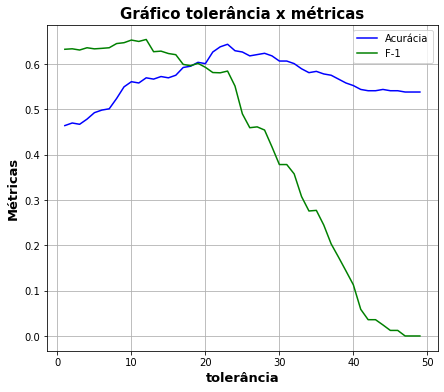

In [42]:
plotar_grafico_scores(lista_scores_ac, lista_scores_f1)

In [43]:
pred = modelo_simples(dados_limpos, tolerancia=tl_max_ac)

In [44]:
confusion_matrix(dados_limpos['ICU'].tolist(), pred)

array([[138,  51],
       [ 74,  88]])

In [45]:
print(classification_report(dados_limpos['ICU'].tolist(), pred))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       189
           1       0.63      0.54      0.58       162

    accuracy                           0.64       351
   macro avg       0.64      0.64      0.64       351
weighted avg       0.64      0.64      0.64       351



Vemos então que para a tolerância que dá a acurácia máxima, temos uma acurácia de 64% o que não é de todo ruim, considerando que o modelo foi construindo 'à mão'. 
vejamos com o outro parâmetro:

In [46]:
pred = modelo_simples(dados_limpos, tolerancia= tl_max_f1)

In [47]:
confusion_matrix(dados_limpos['ICU'].tolist(), pred)

array([[ 57, 132],
       [ 19, 143]])

In [49]:
print(classification_report(dados_limpos['ICU'].tolist(), pred))

              precision    recall  f1-score   support

           0       0.75      0.30      0.43       189
           1       0.52      0.88      0.65       162

    accuracy                           0.57       351
   macro avg       0.64      0.59      0.54       351
weighted avg       0.64      0.57      0.53       351



Melhoramos o f1-score mas a acurácia ficou comprometida. Aqui vemos como temos um jogo de 'toma lá, dá cá': ao passo que melhoramos a precisão 0 e revocação de 1, pioramos sensivelmente a precisão de 1 e revocação de 0. Esse modelo não é de todo ruim para resolver o problema 2, mas é péssimo para resolver o problema 1.
O modelo com o parâmetro anterior era mais equilibrado nesse quesito. 

Mas já que conseguimos criar um modelo com acurácia de 64%, nada abaixo disso será aceitável. Até porque, essa métrica é horrível quando se trata de problemas relacionados a saúde pública. 

# Modelos intermediários

Passemos agora ao desenvolvimento de modelos digamos 'clássicos'. 
Escolhemos atacar o problema utilizando os seguintes modelos:
- Regressão logísitica
- Floresta aleatória
- Vizinhos mais próximos
- XGBoost
- GradientBoosting 
- MLP (Multilayer perceptron)

Para cada um desses modelos, utilizamos um GridSearch para selecionar bons hiperparâmetros. A implementação dos GridSearch não foi feita nesse notebook, mas em três notebook auxiliares, também disponíveis no repositório do Github. Aqui utilizaremos apenas os resultados dessas análises.

Para cada um desses modelos, o procedimento utilizado foi o mesmo:
- Foi criado um modelo base com os hiperparâmetros coletados da análise com GridSearch.
- Utilizamos uma função que roda esse modelo várias vezes, utilizando um RepeatedStratifiedKFold pro debaixo dos panos. 
- Fizemos uma busca por melhores hiperparâmetros para essa função. 
- Comparamos as métricas em todos os passos. 

Em todos esses passos, sempre que possível, utilizamos um random_state = 527435, para garantir a reprodutibilidade dos resultados.

Sem mais delongas, eis as análises:

## Criação de variáveis

In [52]:
features_continuas = dados_limpos.columns[10:-1].tolist()
features_categoricas = dados_limpos.columns[0:9].tolist()

In [53]:
X = dados_limpos.drop('ICU', axis = 1)
y = dados_limpos['ICU']

In [54]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X,y, test_size = 0.25, stratify = y, random_state = 527435)

## Logistic Regression

In [ ]:
modelo_reg_log = LogisticRegression(solver = 'lbfgs',
                                    C = 1.0,
                                    class_weight = None,
                                    fit_intercept = True,
                                    max_iter = 50,
                                    tol = 0.1,
                                    random_state = 527435)

In [ ]:
modelo_reg_log.fit(X_treino, y_treino)
y_pred_reg_log = modelo_reg_log.predict(X_teste)
acur = modelo_reg_log.score(X_teste, y_teste)
print(f"Acurácia = {round(100*acur, 2)}%")

Acurácia = 67.05%


In [ ]:
print(classification_report(y_treino,modelo_reg_log.predict(X_treino)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       142
           1       0.78      0.75      0.77       121

    accuracy                           0.79       263
   macro avg       0.79      0.79      0.79       263
weighted avg       0.79      0.79      0.79       263



In [ ]:
print(classification_report(y_teste,y_pred_reg_log))

              precision    recall  f1-score   support

           0       0.69      0.70      0.69        47
           1       0.65      0.63      0.64        41

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.67      0.67      0.67        88



Temos uma acurácia de 67%. Ou seja, não muito melhor que nosso modelo baseline. 

In [ ]:
y_previsao_reg_log, scores_reg_log = modelo_repetido(modelo_reg_log,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 100,n_folds = 10, tol= 0)

Foram realizadas 1000 iterações
Serão utilizados 1000 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.82      0.57      0.68        47
           1       0.64      0.85      0.73        41

    accuracy                           0.70        88
   macro avg       0.73      0.71      0.70        88
weighted avg       0.73      0.70      0.70        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       0.84      0.65      0.73       142
           1       0.67      0.85      0.75       121

    accuracy                           0.74       263
   macro avg       0.75      0.75      0.74       263
weighted avg       0.76      0.74      0.74       263



Conseguimos subir a acurácia para 70%, o que já é uma melhora considerável em relação ao baseline. Comparando as precisões e as revocações, vemos que parece um bom modelo para lidar com o problema 2.

In [ ]:
print(confusion_matrix(y_teste,y_previsao_reg_log[0]))

[[27 20]
 [ 6 35]]


Vamos agora analizar os parâmetros

In [ ]:
import itertools
df_scores_log_reg = pd.DataFrame(columns=['Repetições', 'Folds', 'Tolerância', 'Acurácia', 'Precisão', 'Revocação', 'F1'])
T = [10*x for x in range(0,11)]
R = [10*x for x in range(1,11)]
F = [5,7,10]
ind = 0
for t,r,f in itertools.product(T,R,F):
  y_previsao, scores_reg_log = modelo_repetido(LogisticRegression(solver= 'liblinear', tol=1.0, C = 1.0, max_iter= 50),
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = r,n_folds = f, tol= t, verbosity = 0)
  ac = scores_reg_log['Acuracia'][0]
  pr = scores_reg_log['Precisão'][0]
  rv = scores_reg_log['Revocação'][0]
  f1 = scores_reg_log['F1'][0]
  nova_coluna = [r,f,t,ac,pr,rv,f1]
  df_scores_log_reg.loc[ind] = nova_coluna
  ind = ind+1
  
df_scores_log_reg

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
0,10.0,5.0,0.0,68.18,62.26,80.49,70.21
1,10.0,7.0,0.0,67.05,61.54,78.05,68.82
2,10.0,10.0,0.0,67.05,62.50,73.17,67.42
3,20.0,5.0,0.0,67.05,61.11,80.49,69.47
4,20.0,7.0,0.0,67.05,61.54,78.05,68.82
...,...,...,...,...,...,...,...
325,90.0,7.0,100.0,68.18,65.12,68.29,66.67
326,90.0,10.0,100.0,68.18,65.12,68.29,66.67
327,100.0,5.0,100.0,68.18,65.12,68.29,66.67
328,100.0,7.0,100.0,68.18,65.12,68.29,66.67


In [ ]:
df_scores_log_reg.groupby(by = 'Repetições').max().sort_values(by = 'Acurácia', ascending = False)

,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
Repetições,,,,,,
10.0,10.0,100.0,72.73,72.97,80.49,70.21
20.0,10.0,100.0,72.73,72.97,80.49,69.47
30.0,10.0,100.0,70.45,68.29,80.49,68.82
40.0,10.0,100.0,70.45,68.29,80.49,68.82
70.0,10.0,100.0,70.45,65.96,80.49,70.45
60.0,10.0,100.0,69.32,65.22,80.49,68.97
80.0,10.0,100.0,69.32,65.22,80.49,69.66
90.0,10.0,100.0,69.32,65.22,80.49,70.33
100.0,10.0,100.0,69.32,65.22,80.49,70.33


Vemos então que os melhores parâmetros são:
Repetições = 20
Folds = 5
Tolerância = 90

Isso dá uma acurácia de 72.73%. Precisão e revocação (para positivos) também não estão ruins. 

Vejamos esse modelo na prática:

In [ ]:
y_previsao, scores = modelo_repetido(LogisticRegression(solver= 'liblinear', tol=1.0, C = 1.0, max_iter= 50),
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 10, verbosity = 1)

Foram realizadas 50 iterações
Serão utilizados 50 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.71      0.68      0.70        47
           1       0.65      0.68      0.67        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       142
           1       0.72      0.73      0.72       121

    accuracy                           0.75       263
   macro avg       0.74      0.74      0.74       263
weighted avg       0.75      0.75      0.75       263



Curiosamente, ao implentar o modelo, vemos uma leve queda nas métricas, apesar de termos tomado todas as medidas para garantir a reprodutibilidade.

## Random Forest

In [ ]:
modelo_forest = RandomForestClassifier(criterion= 'gini', max_depth= 15, max_features= 'log2',
                                class_weight='balanced_subsample', max_samples = 0.6,
                                random_state= 527435)
modelo_forest.fit(X_treino, y_treino)
y_pred_forest = modelo_forest.predict(X_teste)
acur = modelo_forest.score(X_teste, y_teste)
print(f"Acurácia = {round(100*acur, 2)}%")

Acurácia = 68.18%


In [ ]:
print(classification_report(y_treino,modelo_forest.predict(X_treino)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       142
           1       1.00      0.99      1.00       121

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



In [ ]:
print(classification_report(y_teste,y_pred_forest))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        47
           1       0.66      0.66      0.66        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



O modelo Random Forest acabou sofrendo de um terrível overfitting. Em nosso modelo_repetido() será necessário afrouxar a tolerância para overfitting com os dados de teste, caso contrário não rodaremos nenhum modelo.

In [ ]:
y_previsao_forest, scores_forest = modelo_repetido(modelo_forest,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 0,
                             tol_overfit = 1)

Foram realizadas 50 iterações
Serão utilizados 36 modelos no processo
Um total de 14 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.92      0.47      0.62        47
           1       0.61      0.95      0.74        41

    accuracy                           0.69        88
   macro avg       0.76      0.71      0.68        88
weighted avg       0.77      0.69      0.68        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       1.00      0.64      0.78       142
           1       0.70      1.00      0.83       121

    accuracy                           0.81       263
   macro avg       0.85      0.82      0.80       263
weighted avg       0.86      0.81      0.80       263



Notamos agora que melhoramos um pouco a questão do overfitting, porém o resultado com os dados de teste não foram tão satisfatórios. Mas esse modelo se mostra muito bom para tratar do problema 2: ele praticamente acerta todos os pacientes que não necessitam de UTI.

In [ ]:
print(confusion_matrix(y_teste,y_previsao_forest[0]))

[[22 25]
 [ 2 39]]


In [ ]:
print(confusion_matrix(y_treino,y_previsao_forest[1]))

[[ 91  51]
 [  0 121]]


In [ ]:
import itertools
df_scores_forest = pd.DataFrame(columns=['Repetições', 'Folds', 'Tolerância', 'Acurácia', 'Precisão', 'Revocação', 'F1'])
T = [10*x for x in range(0,11)]
R = [10,50,100]
F = [5,7,10]
ind = 0
for t,r,f in itertools.product(T,R,F):
  y_previsao_forest, scores_forest = modelo_repetido(modelo_forest,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = r,n_folds = f, tol= t, verbosity = 0,
                             tol_overfit = 1)
  if scores_forest == False:
    pass
  else:
    ac = scores_forest['Acuracia'][0]
    pr = scores_forest['Precisão'][0]
    rv = scores_forest['Revocação'][0]
    f1 = scores_forest['F1'][0]
    nova_coluna = [r,f,t,ac,pr,rv,f1]
    df_scores_forest.loc[ind] = nova_coluna
    ind = ind+1
  
df_scores_forest

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
0,10.0,5.0,0.0,69.32,60.94,95.12,74.29
1,10.0,7.0,0.0,68.18,60.66,90.24,72.55
2,10.0,10.0,0.0,67.05,59.68,90.24,71.84
3,50.0,5.0,0.0,69.32,60.61,97.56,74.77
4,50.0,7.0,0.0,68.18,60.00,95.12,73.58
...,...,...,...,...,...,...,...
94,50.0,7.0,100.0,69.32,65.91,70.73,68.24
95,50.0,10.0,100.0,67.05,62.50,73.17,67.42
96,100.0,5.0,100.0,68.18,63.27,75.61,68.89
97,100.0,7.0,100.0,69.32,64.00,78.05,70.33


In [ ]:
df_scores_forest.sort_values(by = 'Acurácia', ascending= False)

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
70,100.0,7.0,70.0,71.59,65.38,82.93,73.12
51,100.0,5.0,50.0,71.59,65.38,82.93,73.12
42,100.0,5.0,40.0,70.45,63.64,85.37,72.92
21,50.0,5.0,20.0,70.45,63.64,85.37,72.92
61,100.0,7.0,60.0,70.45,64.15,82.93,72.34
...,...,...,...,...,...,...,...
81,10.0,5.0,90.0,53.41,0.00,0.00,0.00
63,10.0,5.0,70.0,53.41,0.00,0.00,0.00
73,10.0,7.0,80.0,53.41,0.00,0.00,0.00
72,10.0,5.0,80.0,53.41,0.00,0.00,0.00


Melhores parâmetros:
Repetições = 100
Folds = 5
Tolerância = 50

In [ ]:
y_previsao_forest, scores_forest = modelo_repetido(modelo_forest,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 100,n_folds = 5, tol= 50, verbosity = 1,
                             tol_overfit = 1)

Foram realizadas 500 iterações
Serão utilizados 370 modelos no processo
Um total de 130 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.81      0.62      0.70        47
           1       0.65      0.83      0.73        41

    accuracy                           0.72        88
   macro avg       0.73      0.72      0.71        88
weighted avg       0.73      0.72      0.71        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       142
           1       0.86      1.00      0.92       121

    accuracy                           0.92       263
   macro avg       0.93      0.93      0.92       263
weighted avg       0.93      0.92      0.92       263



Aqui novamente notamos o jogo do 'toma lá dá cá': conseguimos melhorar a acurácia, mas às custas de piorar nossa precisão para negativos. Ainda assim, parece ser o melhor modelo até o momento. 

## KNeighbors

In [55]:
modelo_kn = KNeighborsClassifier(algorithm = 'auto',
                                 metric = 'manhattan',
                                 n_neighbors = 14,
                                 weights = 'distance')

modelo_kn.fit(X_treino, y_treino)
y_pred_kn = modelo_kn.predict(X_teste)
acur = modelo_kn.score(X_teste, y_teste)
print(f"Acurácia = {round(100*acur, 2)}%")

Acurácia = 59.09%


In [ ]:
print(classification_report(y_treino,modelo_kn.predict(X_treino)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       121

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



In [ ]:
print(classification_report(y_teste,y_pred_kn))

              precision    recall  f1-score   support

           0       0.59      0.79      0.67        47
           1       0.60      0.37      0.45        41

    accuracy                           0.59        88
   macro avg       0.59      0.58      0.56        88
weighted avg       0.59      0.59      0.57        88



Esse modelo foi péssimo: sofreu um overfitting grande, que fez ter métricas muito ruins nos dados de teste. Nosso modelo baseline é melhor que isso. 

In [ ]:
y_previsao_kn, scores_kn = modelo_repetido(modelo_kn,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 0,
                             tol_overfit = 2)

Foram realizadas 50 iterações
Serão utilizados 50 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.66      0.74      0.70        47
           1       0.66      0.56      0.61        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       142
           1       0.86      1.00      0.92       121

    accuracy                           0.92       263
   macro avg       0.93      0.93      0.92       263
weighted avg       0.93      0.92      0.92       263



Utilizando o modelo_repetido(),conseguimos melhorar um pouco, porém a regressão logística ainda é melhor.

In [ ]:
print(confusion_matrix(y_teste,y_previsao_kn[0]))

[[35 12]
 [18 23]]


In [ ]:
print(confusion_matrix(y_treino,y_previsao_kn[1]))

[[122  20]
 [  0 121]]


In [ ]:
import itertools
df_scores_kn = pd.DataFrame(columns=['Repetições', 'Folds', 'Tolerância', 'Acurácia', 'Precisão', 'Revocação', 'F1'])
T = [10*x for x in range(0,11)]
R = [10,50,100]
F = [5,7,10]
ind = 0
for t,r,f in itertools.product(T,R,F):
  y_previsao_kn, scores_kn = modelo_repetido(modelo_kn,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = r,n_folds = f, tol= t, verbosity = 0,
                             tol_overfit = 2)
  if scores_forest == False:
    pass
  else:
    ac = scores_kn['Acuracia'][0]
    pr = scores_kn['Precisão'][0]
    rv = scores_kn['Revocação'][0]
    f1 = scores_kn['F1'][0]
    nova_coluna = [r,f,t,ac,pr,rv,f1]
    df_scores_kn.loc[ind] = nova_coluna
    ind = ind+1
  
df_scores_kn

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
0,10.0,5.0,0.0,65.91,65.71,56.10,60.53
1,10.0,7.0,0.0,63.64,63.64,51.22,56.76
2,10.0,10.0,0.0,62.50,62.50,48.78,54.79
3,50.0,5.0,0.0,65.91,65.71,56.10,60.53
4,50.0,7.0,0.0,65.91,65.71,56.10,60.53
...,...,...,...,...,...,...,...
94,50.0,7.0,100.0,59.09,58.62,41.46,48.57
95,50.0,10.0,100.0,59.09,58.62,41.46,48.57
96,100.0,5.0,100.0,59.09,58.62,41.46,48.57
97,100.0,7.0,100.0,60.23,60.00,43.90,50.70


In [ ]:
df_scores_kn.sort_values(by = 'Acurácia', ascending=False)

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
0,10.0,5.0,0.0,65.91,65.71,56.1,60.53
15,100.0,5.0,10.0,65.91,65.71,56.1,60.53
3,50.0,5.0,0.0,65.91,65.71,56.1,60.53
4,50.0,7.0,0.0,65.91,65.71,56.1,60.53
5,50.0,10.0,0.0,65.91,65.71,56.1,60.53
...,...,...,...,...,...,...,...
91,10.0,7.0,100.0,53.41,0.00,0.0,0.00
63,10.0,5.0,70.0,53.41,0.00,0.0,0.00
73,10.0,7.0,80.0,53.41,0.00,0.0,0.00
81,10.0,5.0,90.0,53.41,0.00,0.0,0.00


Melhores parâmetros:

Repetições = 10
Folds = 5
Tolerância = 0

In [63]:
y_previsao_kn, scores_kn = modelo_repetido(modelo_kn,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 0, verbosity = 1,
                             tol_overfit = 2)

Foram realizadas 50 iterações
Serão utilizados 50 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.66      0.74      0.70        47
           1       0.66      0.56      0.61        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       142
           1       0.86      1.00      0.92       121

    accuracy                           0.92       263
   macro avg       0.93      0.93      0.92       263
weighted avg       0.93      0.92      0.92       263



## XGBoost

In [58]:
modelo_xgb = XGBClassifier(random_state=527435,
                           booster = 'dart',
                           eta = 0.1,
                           max_depth = 5,
                           sampling_method = 'uniform',
                           subsample = 0.7)

modelo_xgb.fit(X_treino, y_treino)
y_pred_xgb = modelo_xgb.predict(X_teste)
acur = modelo_xgb.score(X_teste, y_teste)
print(f"Acurácia = {round(100*acur, 2)}%")

Acurácia = 75.0%


In [ ]:
print(classification_report(y_treino,modelo_xgb.predict(X_treino)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       121

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



In [ ]:
print(classification_report(y_teste,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        47
           1       0.72      0.76      0.74        41

    accuracy                           0.75        88
   macro avg       0.75      0.75      0.75        88
weighted avg       0.75      0.75      0.75        88



Tivemos novamente um overfitting total, mas as métricas dos dados de testes não estão tão ruins, e até agora se mostraram as mais equilibradas. 
Vejamos se melhoram com o modelo_repetido():

In [ ]:
y_previsao_xgb, scores_xgb = modelo_repetido(modelo_xgb,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 0,
                             tol_overfit = 2)

Foram realizadas 50 iterações
Serão utilizados 50 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.95      0.40      0.57        47
           1       0.59      0.98      0.73        41

    accuracy                           0.67        88
   macro avg       0.77      0.69      0.65        88
weighted avg       0.78      0.67      0.64        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       1.00      0.59      0.74       142
           1       0.68      1.00      0.81       121

    accuracy                           0.78       263
   macro avg       0.84      0.80      0.78       263
weighted avg       0.85      0.78      0.77       263



Novamente, ganha-se em algo e perde-se em outro ponto. Nossa precisão para negativos aumentou consideravelmente, tornando um bom modelo para atacar o problema 2. Na média, entretanto, as métricas pioraram, puxadas pela queda considerável nas outras duas métricas. 

In [ ]:
print(confusion_matrix(y_teste,y_previsao_xgb[0]))

[[19 28]
 [ 1 40]]


In [ ]:
print(confusion_matrix(y_treino,y_previsao_xgb[1]))

[[ 84  58]
 [  0 121]]


In [ ]:
import itertools
df_scores_xgb = pd.DataFrame(columns=['Repetições', 'Folds', 'Tolerância', 'Acurácia', 'Precisão', 'Revocação', 'F1'])
T = [10*x for x in range(0,11)]
R = [10,50,100]
F = [5,7,10]
ind = 0
for t,r,f in itertools.product(T,R,F):
  y_previsao_xgb, xgb_scores = modelo_repetido(modelo_xgb,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = r,n_folds = f, tol= t, verbosity = 0,
                             tol_overfit = 1)
  if xgb_scores == False:
    pass
  else:
    ac = xgb_scores['Acuracia'][0]
    pr = xgb_scores['Precisão'][0]
    rv = xgb_scores['Revocação'][0]
    f1 = xgb_scores['F1'][0]
    nova_coluna = [r,f,t,ac,pr,rv,f1]
    df_scores_xgb.loc[ind] = nova_coluna
    ind = ind+1
  
df_scores_xgb

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
0,10.0,5.0,0.0,70.45,67.44,70.73,69.05
1,10.0,7.0,0.0,72.73,69.77,73.17,71.43
2,50.0,5.0,0.0,73.86,69.57,78.05,73.56
3,50.0,7.0,0.0,67.05,60.00,87.80,71.29
4,50.0,10.0,0.0,73.86,66.67,87.80,75.79
...,...,...,...,...,...,...,...
83,50.0,7.0,100.0,53.41,0.00,0.00,0.00
84,50.0,10.0,100.0,53.41,0.00,0.00,0.00
85,100.0,5.0,100.0,53.41,0.00,0.00,0.00
86,100.0,7.0,100.0,53.41,0.00,0.00,0.00


In [ ]:
df_scores_xgb.sort_values(by = 'Acurácia', ascending= False)

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
14,100.0,7.0,10.0,73.86,71.43,73.17,72.29
2,50.0,5.0,0.0,73.86,69.57,78.05,73.56
4,50.0,10.0,0.0,73.86,66.67,87.80,75.79
5,100.0,5.0,0.0,72.73,67.35,80.49,73.33
1,10.0,7.0,0.0,72.73,69.77,73.17,71.43
...,...,...,...,...,...,...,...
33,10.0,7.0,40.0,53.41,0.00,0.00,0.00
32,10.0,5.0,40.0,53.41,0.00,0.00,0.00
31,100.0,10.0,30.0,53.41,0.00,0.00,0.00
30,100.0,7.0,30.0,53.41,0.00,0.00,0.00


Melhores parâmetros:

Repetições = 50
Folds = 10
Tolerância = 0


In [62]:
y_previsao_xgb, scores_xgb = modelo_repetido(modelo_xgb,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 50,n_folds = 10, tol= 0, verbosity = 1,
                             tol_overfit = 2)

Foram realizadas 500 iterações
Serão utilizados 500 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.95      0.38      0.55        47
           1       0.58      0.98      0.73        41

    accuracy                           0.66        88
   macro avg       0.76      0.68      0.64        88
weighted avg       0.78      0.66      0.63        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       1.00      0.56      0.71       142
           1       0.66      1.00      0.79       121

    accuracy                           0.76       263
   macro avg       0.83      0.78      0.75       263
weighted avg       0.84      0.76      0.75       263



## GradientBoostting

In [60]:
modelo_grad = GradientBoostingClassifier(random_state=527435,
                                         criterion = 'mse',
                                         learning_rate = 0.01,
                                         loss = 'exponential',
                                         max_depth = 5,
                                         max_features = 'log2')

modelo_grad.fit(X_treino, y_treino)
y_pred_grad = modelo_grad.predict(X_teste)
acur = modelo_grad.score(X_teste, y_teste)
print(f"Acurácia = {round(100*acur, 2)}%")

Acurácia = 71.59%


In [ ]:
print(classification_report(y_treino,modelo_grad.predict(X_treino)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       142
           1       1.00      0.89      0.94       121

    accuracy                           0.95       263
   macro avg       0.96      0.95      0.95       263
weighted avg       0.95      0.95      0.95       263



In [ ]:
print(classification_report(y_teste,y_pred_grad))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74        47
           1       0.70      0.68      0.69        41

    accuracy                           0.72        88
   macro avg       0.71      0.71      0.71        88
weighted avg       0.72      0.72      0.72        88



Novamente, um modelo com métricas equilibradas, semelhante ao XGBoost.

In [ ]:
y_previsao_grad, scores_grad = modelo_repetido(modelo_grad,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 0,
                             tol_overfit = 0.97)

Foram realizadas 50 iterações
Serão utilizados 44 modelos no processo
Um total de 6 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.89      0.51      0.65        47
           1       0.62      0.93      0.75        41

    accuracy                           0.70        88
   macro avg       0.76      0.72      0.70        88
weighted avg       0.76      0.70      0.69        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       142
           1       0.71      0.97      0.82       121

    accuracy                           0.81       263
   macro avg       0.84      0.82      0.80       263
weighted avg       0.85      0.81      0.80       263



Como no caso de XGBoost, melhoramos a precisão para negativos, mas a média piorou. 

In [ ]:
print(confusion_matrix(y_teste,y_previsao_grad[0]))

[[24 23]
 [ 3 38]]


In [ ]:
print(confusion_matrix(y_treino,y_previsao_grad[1]))

[[ 95  47]
 [  4 117]]


In [ ]:
import itertools
df_scores_grad = pd.DataFrame(columns=['Repetições', 'Folds', 'Tolerância', 'Acurácia', 'Precisão', 'Revocação', 'F1'])
T = [10*x for x in range(0,11)]
R = [10,50,100]
F = [5,7,10]
ind = 0
for t,r,f in itertools.product(T,R,F):
  y_previsao_grad, grad_scores = modelo_repetido(modelo_grad,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = r,n_folds = f, tol= t, verbosity = 0,
                             tol_overfit = 0.97)
  if grad_scores == False:
    pass
  else:
    ac = grad_scores['Acuracia'][0]
    pr = grad_scores['Precisão'][0]
    rv = grad_scores['Revocação'][0]
    f1 = grad_scores['F1'][0]
    nova_coluna = [r,f,t,ac,pr,rv,f1]
    df_scores_grad.loc[ind] = nova_coluna
    ind = ind+1
  
df_scores_grad

,Repetições,Folds,Tolerância,Acurácia,Precisão,Revocação,F1
0,10.0,5.0,0.0,70.45,62.30,92.68,74.51
1,10.0,7.0,0.0,69.32,62.07,87.80,72.73
2,10.0,10.0,0.0,73.86,65.52,92.68,76.77
3,50.0,5.0,0.0,70.45,61.54,97.56,75.47
4,50.0,7.0,0.0,71.59,62.90,95.12,75.73
...,...,...,...,...,...,...,...
94,50.0,7.0,100.0,71.59,69.05,70.73,69.88
95,50.0,10.0,100.0,71.59,68.18,73.17,70.59
96,100.0,5.0,100.0,70.45,65.31,78.05,71.11
97,100.0,7.0,100.0,70.45,64.71,80.49,71.74


Melhores parâmetros: 

Repetições = 100
Folds = 5
Tolerância = 10

In [61]:
y_previsao_grad, scores_grad = modelo_repetido(modelo_grad,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 100,n_folds = 5, tol= 10, verbosity = 1,
                             tol_overfit = 1)

Foram realizadas 500 iterações
Serão utilizados 500 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.93      0.57      0.71        47
           1       0.66      0.95      0.78        41

    accuracy                           0.75        88
   macro avg       0.80      0.76      0.75        88
weighted avg       0.81      0.75      0.74        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       142
           1       0.74      0.97      0.84       121

    accuracy                           0.83       263
   macro avg       0.85      0.84      0.82       263
weighted avg       0.86      0.83      0.82       263



## MLP

In [64]:
modelo_mlp = MLPClassifier(random_state=527435,
                                         activation = 'relu',
                                         learning_rate = 'constant',
                                         max_iter = 100,
                                         solver = 'adam',
                                         tol = 0.0001)

modelo_mlp.fit(X_treino, y_treino)
y_pred_mlp = modelo_mlp.predict(X_teste)
acur = modelo_mlp.score(X_teste, y_teste)
print(f"Acurácia = {round(100*acur, 2)}%")

Acurácia = 67.05%


In [ ]:
print(classification_report(y_treino,modelo_mlp.predict(X_treino)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       142
           1       0.84      0.76      0.80       121

    accuracy                           0.83       263
   macro avg       0.83      0.82      0.82       263
weighted avg       0.83      0.83      0.82       263



In [ ]:
print(classification_report(y_teste,y_pred_mlp))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69        47
           1       0.64      0.66      0.65        41

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.67      0.67      0.67        88



In [ ]:
y_previsao_mlp, scores_mlp = modelo_repetido(modelo_mlp,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 5, tol= 0,
                             tol_overfit = 0.95)

Foram realizadas 50 iterações
Serão utilizados 50 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        47
           1       0.61      0.76      0.67        41

    accuracy                           0.66        88
   macro avg       0.67      0.67      0.66        88
weighted avg       0.67      0.66      0.66        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       0.84      0.63      0.72       142
           1       0.67      0.86      0.75       121

    accuracy                           0.74       263
   macro avg       0.75      0.75      0.74       263
weighted avg       0.76      0.74      0.74       263



In [ ]:
print(confusion_matrix(y_teste,y_previsao_mlp[0]))

[[27 20]
 [10 31]]


In [ ]:
print(confusion_matrix(y_treino,y_previsao_mlp[1]))

[[ 90  52]
 [ 17 104]]


In [ ]:
import itertools
df_scores_mlp = pd.DataFrame(columns=['Repetições', 'Folds', 'Tolerância', 'Acurácia', 'Precisão', 'Revocação', 'F1'])
T = [10*x for x in range(0,11)]
R = [10,50,100]
F = [5,7,10]
ind = 0
for t,r,f in itertools.product(T,R,F):
  mlp_previsao, mlp_scores = modelo_repetido(melhor_modelo_mlp,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = r,n_folds = f, tol= t, verbosity = 0,
                             tol_overfit = 1)
  if mlp_scores == False:
    pass
  else:
    ac = mlp_scores['Acuracia'][0]
    pr = mlp_scores['Precisão'][0]
    rv = mlp_scores['Revocação'][0]
    f1 = mlp_scores['F1'][0]
    nova_coluna = [r,f,t,ac,pr,rv,f1]
    df_scores_mlp.loc[ind] = nova_coluna
    ind = ind+1
  
df_scores_mlp

In [ ]:
df_scores_mlp.sort_values(by = 'Acurácia', ascending = False)

Melhores parâmetros

Repetições = 10
Folds = 10
Tolerância = 100

In [65]:
y_previsao_mlp, scores_mlp = modelo_repetido(modelo_mlp,
                            X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             n_rep = 10,n_folds = 10, tol= 100, verbosity = 1,
                             tol_overfit = 1)

Foram realizadas 100 iterações
Serão utilizados 100 modelos no processo
Um total de 0 modelos tiveram overfitting com os dados de treino

 || Relatório de classificação (dados de teste) || 

              precision    recall  f1-score   support

           0       0.71      0.77      0.73        47
           1       0.70      0.63      0.67        41

    accuracy                           0.70        88
   macro avg       0.70      0.70      0.70        88
weighted avg       0.70      0.70      0.70        88


 || Relatório de classificação (dados de treino) || 

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       142
           1       0.00      0.00      0.00       121

    accuracy                           0.54       263
   macro avg       0.27      0.50      0.35       263
weighted avg       0.29      0.54      0.38       263



# Modelo Final 

Finalmente, iremos construir nosso modelo com base em todos os modelos intermediários.

In [ ]:
def varios_modelos_repetidos(X_train, y_train, X_test, y_test, tol = 0, prob = False):
  modelo_reg_log = LogisticRegression(solver = 'lbfgs',
                                    C = 1.0,
                                    class_weight = None,
                                    fit_intercept = True,
                                    max_iter = 50,
                                    tol = 0.1,
                                    random_state = 527435)
  modelo_forest = RandomForestClassifier(criterion= 'gini', max_depth= 15, max_features= 'log2',
                                class_weight='balanced_subsample', max_samples = 0.6,
                                random_state= 527435)
  modelo_kn = KNeighborsClassifier(algorithm = 'auto',
                                 metric = 'manhattan',
                                 n_neighbors = 14,
                                 weights = 'distance')
  modelo_xgb = XGBClassifier(random_state=527435,
                           booster = 'dart',
                           eta = 0.1,
                           max_depth = 5,
                           sampling_method = 'uniform',
                           subsample = 0.7)
  modelo_grad = GradientBoostingClassifier(random_state=527435,
                                         criterion = 'mse',
                                         learning_rate = 0.01,
                                         loss = 'exponential',
                                         max_depth = 5,
                                         max_features = 'log2')
  modelo_mlp = MLPClassifier(random_state=527435,
                                         activation = 'relu',
                                         learning_rate = 'constant',
                                         max_iter = 100,
                                         solver = 'adam',
                                         tol = 0.0001)


  lista_prev_parc = []

  prev_log_reg, log_reg_sc = modelo_repetido(modelo_reg_log,
                                             X_train = X_train, y_train = y_train,
                                             X_test = X_test, y_test = y_test,
                                             n_rep = 20, n_folds = 5, tol = 90, verbosity = 0, prob = prob)
  if prev_log_reg == False:
    print('Modelo Logistic Regression não retornou resultado')
  else:
    if prob == False:
      lista_prev_parc.append(prev_log_reg[0])
    else:
      lista_prev_parc.append(prev_log_reg)

  prev_forest, forest_sc = modelo_repetido(modelo_forest,
                                             X_train = X_train, y_train = y_train,
                                             X_test = X_test, y_test = y_test,
                                             n_rep = 100, n_folds = 5, tol = 50,
                                           tol_overfit = 1, verbosity = 0, prob = prob)
  if prev_forest == False:
    print('Modelo Random Forest não retornou resultado')
  else:
    if prob == False:
      lista_prev_parc.append(prev_forest[0])
    else:
      lista_prev_parc.append(prev_forest)
  
  prev_kn, kn_sc = modelo_repetido(modelo_kn,
                                             X_train = X_train, y_train = y_train,
                                             X_test = X_test, y_test = y_test,
                                             n_rep = 10, n_folds = 5, tol = 0,
                                   tol_overfit = 2, verbosity = 0, prob = prob)
  if prev_kn == False:
    print('Modelo KNeighborns não retornou resultado')
  else:
    if prob == False:
      lista_prev_parc.append(prev_kn[0])
    else:
      lista_prev_parc.append(prev_kn)
  
  prev_xgb, xgb_sc = modelo_repetido(modelo_xgb,
                                             X_train = X_train, y_train = y_train,
                                             X_test = X_test, y_test = y_test,
                                             n_rep = 50, n_folds = 10, tol = 0,
                                     tol_overfit = 1,verbosity = 0, prob = prob)
  if prev_xgb == False:
    print('Modelo XGB não retornou resultado')
  else:
    if prob == False:
      lista_prev_parc.append(prev_xgb[0])
    else:
      lista_prev_parc.append(prev_xgb)
  
  prev_grad, grad_sc = modelo_repetido(modelo_grad,
                                             X_train = X_train, y_train = y_train,
                                             X_test = X_test, y_test = y_test,
                                             n_rep = 100, n_folds = 5, tol = 10,
                                            tol_overfit = 1, verbosity = 0, prob = prob)
  if prev_grad == False:
    print('Modelo Gradient Boosting não retornou resultado')
  else:
    if prob == False:
      lista_prev_parc.append(prev_grad[0])
    else:
      lista_prev_parc.append(prev_grad)
  
  prev_mlp, mlp_sc = modelo_repetido(modelo_kn,
                                             X_train = X_train, y_train = y_train,
                                             X_test = X_test, y_test = y_test,
                                             n_rep = 10, n_folds = 10, tol = 100,
                                     tol_overfit = 2, verbosity = 0, prob = prob)
  if prev_mlp == False:
    print('Modelo MLP não retornou resultado')
  else:
    if prob == False:
      lista_prev_parc.append(prev_mlp[0])
    else:
      lista_prev_parc.append(prev_mlp)    


  prev_final = compara_lista_series_binarias(lista_prev_parc, tolerancia= tol)

  print(classification_report(y_test, prev_final))

  return prev_final

In [ ]:
for tl in [0,1,2,3,4,5,6]:
  y_prev = varios_modelos_repetidos(X_train =  X_treino, y_train =  y_treino,
                             X_test =  X_teste, y_test =  y_teste,
                             tol = tl)

              precision    recall  f1-score   support

           0       0.92      0.51      0.66        47
           1       0.63      0.95      0.76        41

    accuracy                           0.72        88
   macro avg       0.78      0.73      0.71        88
weighted avg       0.79      0.72      0.70        88

              precision    recall  f1-score   support

           0       0.89      0.53      0.67        47
           1       0.63      0.93      0.75        41

    accuracy                           0.72        88
   macro avg       0.76      0.73      0.71        88
weighted avg       0.77      0.72      0.71        88

              precision    recall  f1-score   support

           0       0.86      0.66      0.75        47
           1       0.69      0.88      0.77        41

    accuracy                           0.76        88
   macro avg       0.78      0.77      0.76        88
weighted avg       0.78      0.76      0.76        88

              preci

Percebemos que tolerância = 2 é a melhor parâmetro.
Obtivemos uma acurácia de 77%, a maior até o momento. Olhando para as outras métricas, percebemos os f1 scores também acima de 75%, o que também foram os melhores até o momento. 

Como na maioria dos modelos que vimos, esse também parece ser mais adequado para lidar com o problema 2.

# Resumo e considerações finais

Criamos um modelo baseline 'na mão' que nos dava uma acurácia de 64%. Com excessão do kneighbors, todos os outros modelos tiveram melhor desempenho que o modelo de base. 

Para certas escolhas de parâmetros, os modelos RandomForest, XGBoost e GradientBoosting são excelentes para lidar com o problema 2: prever que um paciente não vai para a UTI. 

No entanto, nenhum dos modelos foi realmente bom para atacar o problema 1: prever que um paciente vai para a UTI. 

De modo que em resumo, podemos dizer que temos um modelo que responde o problema 2, mas não temos um modelo que responde o problema 1.

Nosso modelo final é o que tem a melhor compensação entre equilíbrio entre as métricas e métricas boas. No entanto, não seria realmente bom para atacar um dos dois problemas, apesar de se sair razoavelmente bem com o problema 2.

Alguns pontos que podem ser melhorados nesse projeto, como um todo:
- Explorar técnicas melhores de tunnig de hiperparâmetros. GridSearch é muito custoso computacionalmente falando.
- Implementar as funções criadas aqui nesse notebook como métodos dentro de uma classe.

Ideias que podem ser exploradas na tentativa de melhorar os modelos:
- Tentar outras maneiras de fazer o 'emsamble' de modelos, dando pesos diferentes para cada um. 
- Incluir de alguma forma o modelo de base no emsamble.
- Tentar modelos que não forma utilizados aqui, como por exemplo SVC e Redes Neurais. 

Além disso, podemos melhorar outras perspecitivas como por exemplo, fazer um 'feature engineering' diferente do que foi feito no notebook de preparação de dados e análise exploratória. 

Por fim, podemos mudar o problema e tentar utilizar isso a nosso favor. 
Experimentamos um modelo RandomForest com hiperâmetros padrões, sem feature engineering complexa nos dados que tenta prever se um paciente vai para a UTI na janela seguinte. Obtivemos valores em torno de 98% em todas as métricas. 
Obviamente, esse não é o problema inicial, e na prática pode ser inútil prever se um paciente vai precisar de UTI nas próximas 2 horas. É provável que os testes sanguíneos nem estejam prontos nesse intervalo de tempo.
Porém, pode ser útil utilizar esse modelo para prever quais são os pacientes mais imediatos e então tentar utilizar outros modelos em outros pacientes. Explicando melhor, se esse modelo prever que um paciente não irá para a UTI na próxima janela, podemos jogar os dados desse paciente em outro modelo menos acurado que prevê se ele vai precisar de UTI em janelas de tempo mais distantes.
Outra ideia é tentar utilizar apenas os sinais vitais (que podem ser medidas quase que em tempo real) como variáveis que serão jogadas nos modelos. 
Tudo isso são ideias para projetos futuros. 